In [1]:
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os

In [2]:
carpeta = (os.getcwd()+'/tc02Data/')

# Nombres de los archivos: yeast_(...).txt
archivos = ['Y2H','AP-MS','LIT','LIT_Reguly']

# Lista donde se van a ir agregando los grafos en el orden de los archivos
Gs = []

for j,archivo in enumerate(archivos):
    data = pd.read_csv(carpeta+'yeast_'+archivo+'.txt', sep='\t', header=None)
    
    G = nx.Graph()
    
    for i in range(len(data)):
        G.add_edges_from([(data[0][i],data[1][i])])
    Gs.append(G)

# El último archivo, LIT_Reguly, es el único que tiene encabezado
# Quise poner header automático pero devuelve un error, así que elimino lo que sobra a lo bruto
Gs[3].remove_node("Bait gene/protein")
Gs[3].remove_node("Hit gene/protein")

In [3]:
# Proteinas esenciales
data_ess = pd.read_csv(carpeta+'Essential_ORFs_paperHe.txt', sep='\t', header=0,skipfooter=4,usecols=[1])

# Para eliminar los espacios en los nombres de las proteinas
data_ess['ORF_name'] = data_ess['ORF_name'].map(lambda x: x.strip())

ess = data_ess["ORF_name"].tolist()
del ess[0] # como antes, elimino el encabezado

# ess es la lista de proteinas esenciales

C:\Users\Luli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [4]:
# Agrego la caracteristica de ser o no esencial

for G in Gs:
    nodos_G = set(G.nodes()) # set de nodos de G
    nodos_ess_G = nodos_G.intersection(set(ess)) # nodos esenciales de G (como interseccion entre nodos de G y esenciales)
    nodos_no_ess_G = nodos_G.difference(set(ess)) # nodos no esenciales de G (como diferencia entre nodos de G y esenciales)
    
    # Agrego el atributo correspondiente a cada nodo
    G.add_nodes_from(nodos_ess_G, essential=True)
    G.add_nodes_from(nodos_no_ess_G, essential=False)

# Para comprobarlo me fije que la cantidad de nodos sea la misma antes y despues de esto

In [34]:
G = Gs[3]
grados_dict = dict(G.degree())
ess_dict = nx.get_node_attributes(G,'essential')

k_lista = list(grados_dict.values()) # lista de grados de nodos en orden
k = np.unique(k_lista) # vector de grado de nodos sin repetir

L = len(k)
nodos_ess = np.zeros(L)
nodos_total = np.zeros(L)
nodos_frac = np.zeros(L)

N = G.number_of_nodes()

for i,grado in enumerate(k):
    nodos_total[i] = k_lista.count(grado)
    # cuenta cuantas veces aparece cada grado en k_lista
    
for proteina in ess_dict:
    if ess_dict[proteina] == True:
        i = np.where(k == grados_dict[proteina])
        nodos_ess[i] += 1
    

nodos_frac = nodos_ess / nodos_total


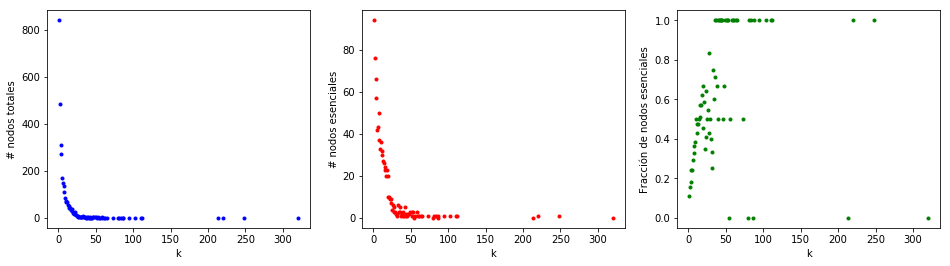

In [35]:
plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.plot(k,nodos_total,'.b')
plt.xlabel('k')
plt.ylabel('# nodos totales')

plt.subplot(1,3,2)
plt.plot(k,nodos_ess,'.r')
plt.xlabel('k')
plt.ylabel('# nodos esenciales')

plt.subplot(1,3,3)
plt.plot(k,nodos_frac,'.g')
plt.xlabel('k')
plt.ylabel('Fracción de nodos esenciales')

plt.show()

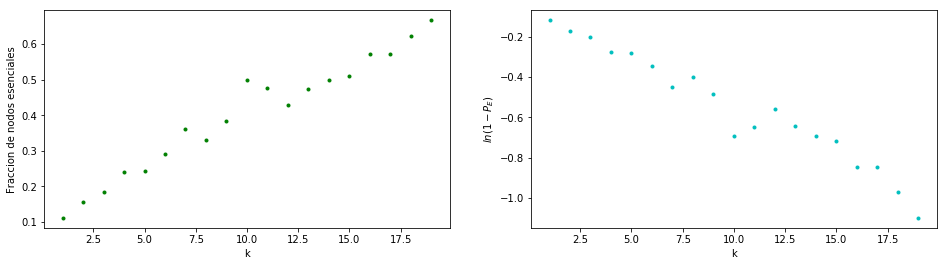

In [56]:
# Ojo: truncar los datos en algún grado, por ej 20 (en el paper lo hacen en 10)
# porque para grados mayores no hay estadistica
# NO hacer acumulativo, porque cambiaría el criterio de bineado y esta mal

menos_Pe = np.log(1 - nodos_frac[0:19])

plt.figure(figsize=(16, 4))

plt.subplot(1,2,1)
plt.plot(k[0:19],nodos_frac[0:19],'.g')
plt.xlabel('k')
plt.ylabel('Fraccion de nodos esenciales')

plt.subplot(1,2,2)
plt.plot(k[0:19],menos_Pe,'.c')
plt.xlabel('k')
plt.ylabel('$ln(1-P_E)$')

plt.show()